# Проект: вариант 2
### Задание 1. A/B–тестирование

1.1 Условие
- Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
# функция на случай если будут появляться ошибки, чтобы их убирать
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
sns.set(rc={'figure.figsize': (16, 6)}, style='whitegrid')  # настройка графиков

In [5]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # преобразовывает экспоненциальные формат в норм формат

1.2 Входные данные 
- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### План

1. **Сначала сделаем небольшой препроцессинг:**
    - прочитаем файлы;
    - Посмотрим на данные;
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Создадим метрики CR, ARPU, ARPPU
    - Построим графики
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было

In [6]:
# прочитаем файлы и посмотрим какие уникальные значения содержатся, также надо найти файлы, которые имеют связи между
# чтобы их соединить и провести расчеты метрик 

groups = pd.read_csv(os.getcwd() + '/groups.csv', sep=';')
groups_add = pd.read_csv(os.getcwd() + '/group_add.csv')
active_studs = pd.read_csv(os.getcwd() + '/active_studs.csv')
checks = pd.read_csv(os.getcwd() + '/checks.csv', sep=';')

In [7]:
groups.dtypes

id      int64
grp    object
dtype: object

In [8]:
print(groups.describe(include='object'))  # описание типа object
print(f'уникальные id:', {groups.id.nunique()})

          grp
count   74484
unique      2
top         B
freq    59813
уникальные id: 74484


In [9]:
groups.describe()  # краткое описание датасета 

,id
count,74484.00
mean,2133751.55
std,1531422.90
min,1489.00
25%,917498.00
50%,1667190.50
75%,3322954.75
max,5694419.00


In [10]:
groups.head(2)

,id,grp
0,1489,B
1,1627,A


In [11]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [12]:
print(groups_add.describe(include='object'))  # описание типа object
print(f'уникальные id: {groups_add.id.nunique()}')

       grp
count   92
unique   2
top      B
freq    70
уникальные id: 92


In [13]:
groups_add.head(2)

,id,grp
0,5694584,B
1,5694830,B


In [14]:
# имеются ли id из добавочного файла в файле group
ids = groups_add.id
groups.query('id in @ids')

,id,grp


In [15]:
# кросс-чекни в обратном порядке 
idsgroup = groups.id
groups_add.query('id in @idsgroup')

,id,grp


In [16]:
# удостоверимся что id не повторяются в датасетах
print(f'the ids not in groups & groups_add: {groups.query('id not in @ids').shape[0]}')
print(f'the ids not in groups_add & groups: {groups_add.query('id not in @idsgroup').shape[0]}')

the ids not in groups & groups_add: 74484
the ids not in groups_add & groups: 92


In [17]:
active_studs.head(2)

,student_id
0,581585
1,5723133


In [18]:
active_studs.dtypes

student_id    int64
dtype: object

In [19]:
print(f'unique values: {active_studs.nunique()}')
print(active_studs.describe(include='int64'))


unique values: student_id    8341
dtype: int64
       student_id
count     8341.00
mean   2448546.69
std    1564978.36
min       1627.00
25%    1118405.00
50%    2094192.00
75%    3638877.00
max    5951797.00


In [20]:
checks.head(2)

,student_id,rev
0,1627,990.00
1,3185,690.00


In [21]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [22]:
print(f'unique student_id values: {checks.student_id.nunique()}')
print(checks.describe(include='int64'))

unique student_id values: 541
       student_id
count      541.00
mean   2514771.83
std    1726838.92
min       1627.00
25%     987129.00
50%    2526021.00
75%    3993249.00
max    5740903.00


In [23]:
# удостоверимся что id не повторяются в датасетах
print(f'the ids not in active_studs into checks: {active_studs.query('student_id not in @checks.student_id').shape[0]}')
print(f'the ids not in checks into active_studs: {checks.query('student_id not in @active_studs.student_id').shape[0]}')

the ids not in active_studs into checks: 7949
the ids not in checks into active_studs: 149


In [24]:
# посмотрим имеются ли нулевые значения в датасетах 
print(f'количество нулевых значении в groups: {groups.isna().sum()}')
print(f'количество нулевых значении в groups_add: {groups_add.isna().sum()}')
print(f'количество нулевых значении в active_studs: {active_studs.isna().sum()}')
print(f'количество нулевых значении в checks: {checks.isna().sum()}')

количество нулевых значении в groups: id     0
grp    0
dtype: int64
количество нулевых значении в groups_add: id     0
grp    0
dtype: int64
количество нулевых значении в active_studs: student_id    0
dtype: int64
количество нулевых значении в checks: student_id    0
rev           0
dtype: int64


In [25]:
# имеются ли student_id из добавочного файла в файле groups_add и наоборот
print(f'пользователи в groups_add & active_studs: {groups_add.query('id in @active_studs.student_id').shape[0]}')
print(f'пользователи в active_studs & groups_add: {active_studs.query('student_id in @groups_add.id').shape[0]}')

пользователи в groups_add & active_studs: 13
пользователи в active_studs & groups_add: 13


In [26]:
# имеются ли student_id из добавочного файла в файле groups_add и наоборот
print(f'пользователи в groups_add & checks: {groups_add.query('id in @checks.student_id').shape[0]}')
print(f'пользователи в checks & groups_add: {checks.query('student_id in @groups_add.id').shape[0]}')

пользователи в groups_add & checks: 1
пользователи в checks & groups_add: 1


In [27]:
print(f'пользователи нет в groups_add & checks: {groups_add.query('id not in @checks.student_id').shape[0]}')
print(f'пользователи нет в checks & groups_add: {checks.query('student_id not in @groups_add.id').shape[0]}')

пользователи нет в groups_add & checks: 91
пользователи нет в checks & groups_add: 540


In [28]:
print(f'пользователи нет в groups_add & active_studs: {groups_add.query('id not in @active_studs.student_id').shape[0]}')
print(f'пользователи нет в active_studs & groups_add: {active_studs.query('student_id not in @groups_add.id').shape[0]}')

пользователи нет в groups_add & active_studs: 79
пользователи нет в active_studs & groups_add: 8328


In [29]:
# в итоге можем объединять файл groups с groups_add и проверим количество строк 
# далее объединенный файл проверим по такой же логике проверки что и выше с файлами checks & active_studs

In [30]:
concat_df_groups_groupsadd = pd.concat([groups, groups_add])

In [31]:
concat_df_groups_groupsadd.head(2)

,id,grp
0,1489,B
1,1627,A


In [32]:
concat_df_groups_groupsadd.shape[0] - groups.shape[0] - groups_add.shape[0]  # все ок. не потеряли данные 

0

In [33]:
print(concat_df_groups_groupsadd.grp.value_counts())
print(f'процентное соотношение групп: 
{concat_df_groups_groupsadd.grp.value_counts(normalize=True)}')
print(f'общее количество пользователей: {concat_df_groups_groupsadd.shape[0]}')

B    59883
A    14693
Name: grp, dtype: int64
процентное соотношение групп: 
 B   0.80
A   0.20
Name: grp, dtype: float64
общее количество пользователей: 74576


''' в итоге получается ''' 
- 74576 - пользователей 
- 8341 - количество активных пользователей, из них: 7949 - пользовались но нет в checks, получается не оплатили в дни проведения эксперимента 
- 541 - количество оплативших пользователей, из них: 149 - оплатили, но их нет в списке active_studs (в файле с информацией о пользователе)
> Для заметки: странно что оплатившие пользователи не попали в группу пользователей в файлу activ_studs, возможно это какой-то баг. 

In [34]:
# Далее объединим два файла activ & checks 
merge_df_activ_checks = active_studs.merge(checks, how='left', on='student_id')

In [35]:
merge_df_activ_checks.head(2)

,student_id,rev
0,581585,nan
1,5723133,nan


In [36]:
merge_df_activ_checks.shape

(8341, 2)

In [37]:
merge_df_activ_checks.isna().sum()

student_id       0
rev           7949
dtype: int64

In [38]:
concat_df_groups_groupsadd.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [39]:
# далее выберем и объединим concat_df_groups_groupsadd, но для начала поменяем название колонки чтобы делать merge 
concat_df_groups_groupsadd = concat_df_groups_groupsadd.rename(columns={'id': 'student_id'})


In [40]:
merge_all = merge_df_activ_checks.merge(concat_df_groups_groupsadd, how='left', on='student_id')

In [41]:
merge_all.head()

,student_id,rev,grp
0,581585,nan,A
1,5723133,nan,A
2,3276743,nan,B
3,4238589,nan,A
4,4475369,nan,B


In [42]:
merge_all.shape[0] - merge_df_activ_checks.shape[0]  # данные не потеряны 

0

In [43]:
# уберем нулевые столбцы 
merge_all = merge_all.fillna(0)

In [44]:
merge_all.head()

,student_id,rev,grp
0,581585,0.00,A
1,5723133,0.00,A
2,3276743,0.00,B
3,4238589,0.00,A
4,4475369,0.00,B


In [45]:
merge_all[merge_all.rev != 0].shape[0]

392

In [46]:
merge_all[merge_all.rev != 0].grp.value_counts()

B    314
A     78
Name: grp, dtype: int64

In [47]:
merge_all.dtypes

student_id      int64
rev           float64
grp            object
dtype: object

In [48]:
group_data_A = merge_all[(merge_all.rev!= 0) & (merge_all.grp == 'A')]

In [49]:
group_data_A.head()  # оплатили из группы А

,student_id,rev,grp
62,1184303,1530.00,A
99,720651,1980.00,A
306,4337103,580.00,A
392,332387,2910.00,A
439,1659434,690.00,A


In [50]:
group_data_B = merge_all[(merge_all.rev != 0) & (merge_all.grp == 'B')]

In [51]:
group_data_B.head()  # оплатили из группы B

,student_id,rev,grp
67,3354191,1900.00,B
77,3278734,1900.00,B
193,1232221,1900.00,B
195,3821501,1900.00,B
211,1036096,1900.00,B


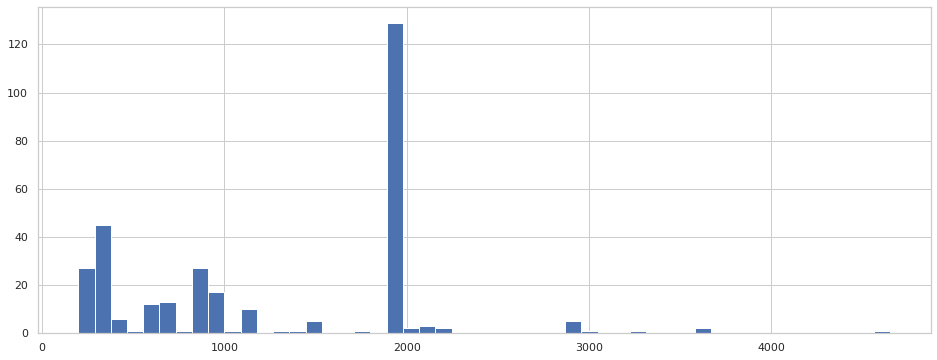

In [52]:
plt.hist(group_data_B.rev, bins=50)
plt.style.use('ggplot')
plt.show()

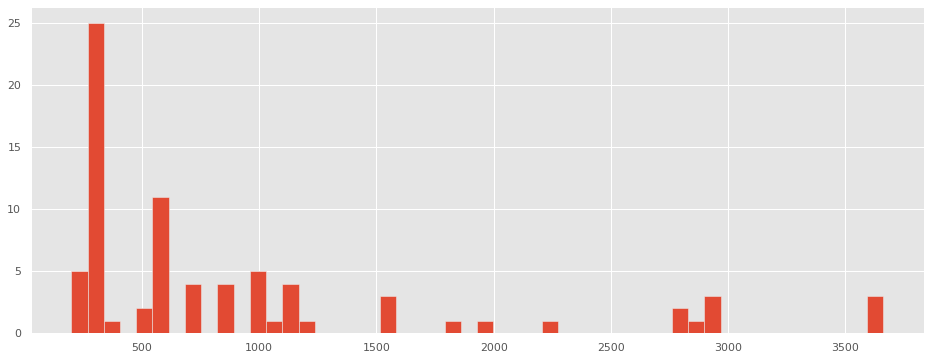

In [53]:
plt.hist(group_data_A.rev, bins=50)
plt.style.use('ggplot')
plt.show()

In [54]:
# посмотрим на распределение по нулевым rev, то есть не оплативших 
group_data_A_0 = merge_all[(merge_all.rev == 0) & (merge_all.grp == 'A')]

In [55]:
group_data_A_0.head()

,student_id,rev,grp
0,581585,0.00,A
1,5723133,0.00,A
3,4238589,0.00,A
7,1394612,0.00,A
21,5194768,0.00,A


In [56]:
group_data_B_0 = merge_all[(merge_all.rev == 0) & (merge_all.grp == 'B')]

In [57]:
group_data_B_0.head()

,student_id,rev,grp
2,3276743,0.00,B
4,4475369,0.00,B
5,5481015,0.00,B
6,1353433,0.00,B
8,1170611,0.00,B


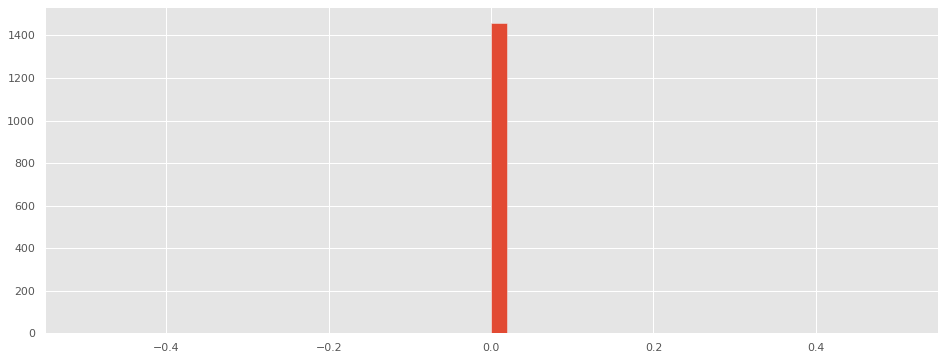

In [58]:
plt.hist(group_data_A_0.rev, bins=50)
plt.style.use('ggplot')
plt.show()

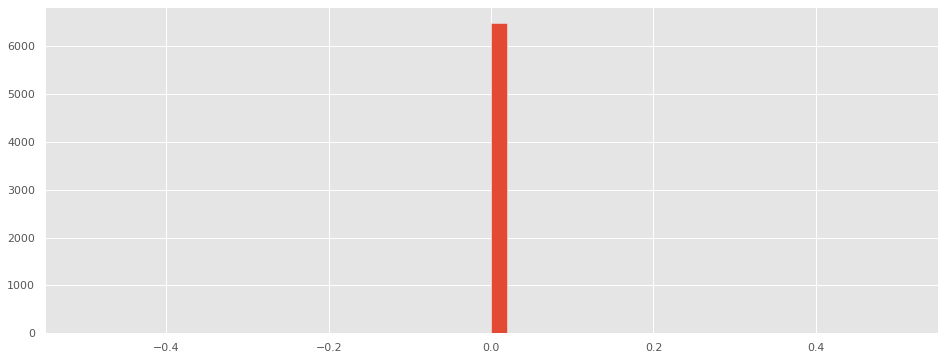

In [59]:
plt.hist(group_data_B_0.rev, bins=50)
plt.style.use('ggplot')
plt.show()

думаю в обязательном порядке нужно расчитать:
- Конверсию (conversion rate) по распределенным группам, которая означает отношение числа пользователей, совершивших целевое действие на определенном этапе, к общему числу тех, кто дошел до данного этапа;
- ARPU (средний доход на пользователя) - отношение дохода за определенный период на количество уникальных посетителей за тот же период;
- ARPPU (средний доход на платящего пользователя) - это метрика, которая показывает среднюю прибыль от одного платящего   пользователя за определенный период времени. Она позволяет измерять ценность продукта компании и прогнозировать доход.

In [60]:
print(f'CR для группы B = {round((group_data_B.student_id.count() / group_data_B_0.student_id.count()) * 100, 2)}')
print(f'CR для группы A = {round((group_data_A.student_id.count() / group_data_A_0.student_id.count()) * 100, 2)}')

CR для группы B = 4.84
CR для группы A = 5.34


In [61]:
print(f'ARPU по группе B = {round(group_data_B.rev.sum() / group_data_B_0.student_id.count(), 2)}')
print(f'ARPU по группе A = {round(group_data_A.rev.sum() / group_data_A_0.student_id.count(), 2)}')

ARPU по группе B = 60.87
ARPU по группе A = 49.88


In [62]:
print(f'ARPPU по группе B = {round(group_data_B.rev.mean(), 2)}')
print(f'ARPPU по группе A = {round(group_data_A.rev.mean(), 2)}')

ARPPU по группе B = 1257.88
ARPPU по группе A = 933.59


In [63]:
# невооруженным глазом заметно, что по вышеуказанным метрикам, группы А и В различаются между собой. Но чтобы быть 
# наверняка уверенным, применим ниже функцию bootstrap для тестирования и утвердимся в наших заключениях. 

In [64]:
# импортируем нужные библиотеки для проверки гипотез
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [65]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

In [66]:
def CR(x):
    ''' расчитаем CR для применения ее в statistic в функции bootstrap'''
    return sum(x) / len(x)
def ARPU(y):
    ''' расчитаем ARPU для применения ее в statistic в функции bootstrap'''
    return np.mean(y)
def ARPPU(y):
    ''' расчитаем ARPPU для применения ее в statistic в функции bootstrap'''
    return np.mean(y)

- Н0 - нулевая гипотеза, CR не различаются между группами
- Н1 - альтернативная гипотеза

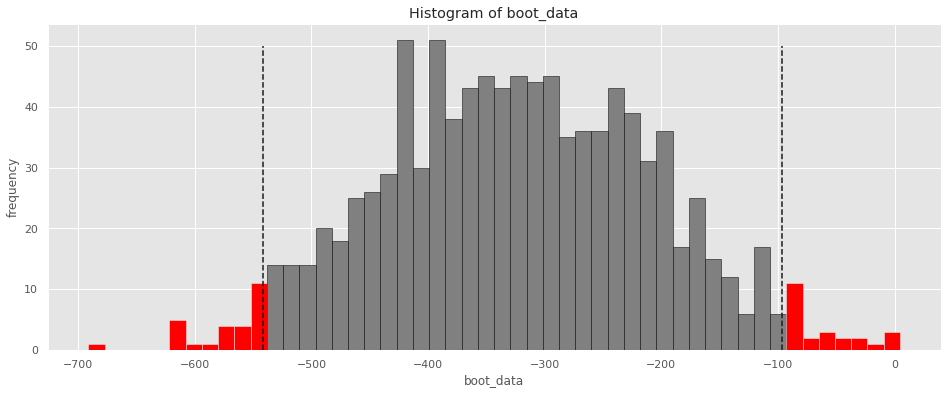

{'quants':            0
 0.03 -541.22
 0.97  -96.29,
 'p_value': 0.005173246338379786}

In [67]:
get_bootstrap(group_data_A.rev, group_data_B.rev, statistic=CR)

- Н0 - нулевая гипотеза, ARPU не различаются между группами
- Н1 - альтернативная гипотеза

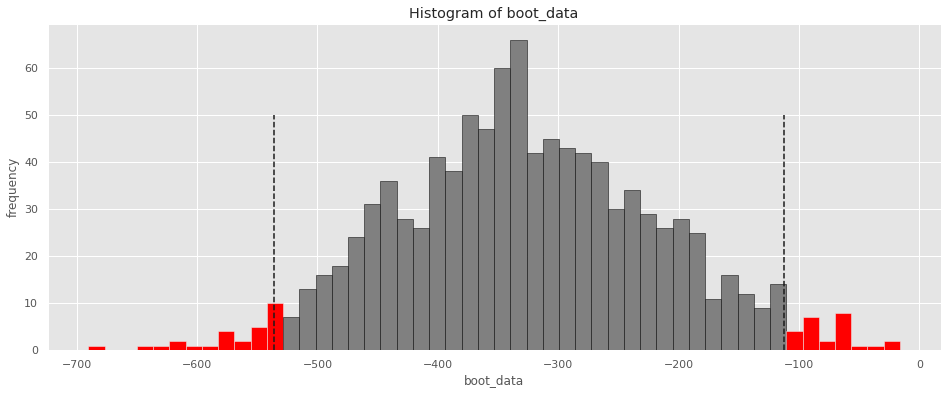

{'quants':            0
 0.03 -535.72
 0.97 -112.38,
 'p_value': 0.002541567152662068}

In [68]:
get_bootstrap(group_data_A.rev, group_data_B.rev, statistic=ARPU)


- Н0 - нулевая гипотеза, ARPPU не различаются между группами
- Н1 - альтернативная гипотеза

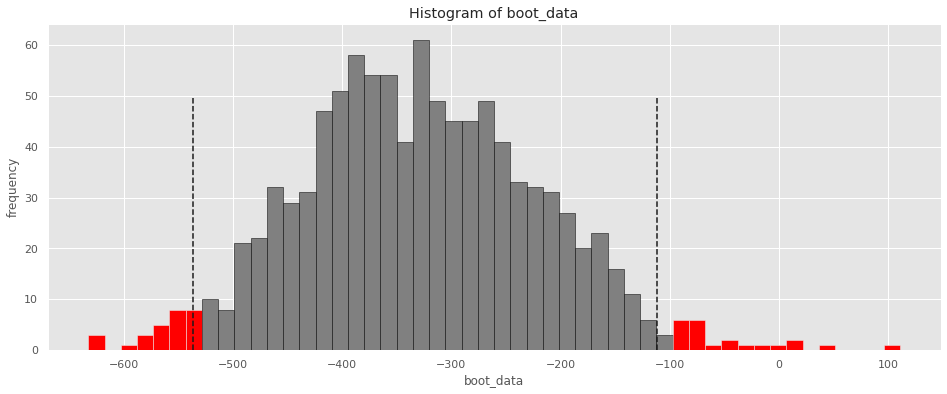

{'quants':            0
 0.03 -537.04
 0.97 -112.04,
 'p_value': 0.002588402977429521}

In [69]:
get_bootstrap(group_data_A.rev, group_data_B.rev, statistic=ARPPU)

In [70]:
# 


MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

In [71]:
# можем также расчитать t-test  с помощью pingouin 
from statsmodels.stats.weightstats import ttest_ind
import pingouin as pg

In [72]:
result = pg.ttest(group_data_A.rev, group_data_B.rev, correction=True)
print(result)

           T    dof alternative  p-val              CI95%  cohen-d   BF10  \
T-test -2.86 106.98   two-sided   0.01  [-548.94, -99.64]     0.40  6.536   

        power  
T-test   0.88  


In [73]:
# проверим еще через statsmodels
ttest_ind(group_data_A.rev, group_data_B.rev)

(-3.1337795050931008, 0.0018562025265765703, 390.0)

> все сводится к тому, что
pvalue < 0.05, который значит, что имеются статически значимые различия между группой А и группой В.
соответственно мы отвергаем нулевую гипотезу об отсутствии различии. 
Результатом тестирования стал, что можно запускать новую механику для пользователей 

### Задание 2. SQL

***2.1.2 Задача: Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.***

In [ ]:
SELECT COUNT(DISTINCT st_id) unique_students          -- выбор уникальных студентов
FROM (                                                -- в подзапросе выполняем расчеты по месяцу  
  SELECT st_id, SUM(correct) OVER w AS solve_in_month
  FROM peas
  WHERE date_part('month', timest) = 1 AND date_part('year', timest) = 2022
  WINDOW w AS (PARTITION BY st_id ORDER BY timest ASC RANGE BETWEEN '1 month' PRECEDING AND CURRENT ROW) -- кол-во правильных ответов
) AS t1 -- группировка, сортировка, расчет в теч месяца
WHERE solve_in_month >= 20

***2.2.2 Задача: Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:***
- ARPU 
- ARPAU
- CR в покупку
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

***ARPU считается относительно всех пользователей, попавших в группы. 
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.***

In [ ]:
1 Надо найти Активного пользователя в целом для расчета CR 
2 Надо найти активного пользователя по математике для расчета CR 
3 пропишем все формулы и столбцы которые будем использовать для агрегации

In [ ]:
select
    studs.test_grp,
    SUM(sold_subjects.sum_money) / COUNT(msit.st_id) AS ARPU,
    SUM(sold_subjects.sum_money) / SUM(msit.max_solve_in_total) AS ARPAU,
    SUM(sold_subjects.whole_subject)::float / COUNT(msit.st_id) AS CR, -- CR по всем предметам 
    SUM(CASE WHEN msit.max_solve_in_total = 1 AND sold_subjects.whole_subject = 1 THEN 1 ELSE 0 END)::float / SUM(msit.max_solve_in_total) AS СR_aktiv_users,
    SUM(CASE WHEN ms.math_solve = 1 AND sold_subjects.math_sold = 1 THEN 1 ELSE 0 END)::float / SUM(ms.math_solve) AS CR_math
FROM
-- ''' 1 Надо найти Активного пользователя в целом для расчета CR '''
    (select 
        t1.st_id,
        max(CASE when t1.solve_in_one_day >=30 then 1 else 0 END) max_solve_in_total
    FROM 
        (SELECT
            st_id,
            timest,
            subject,
            sum(correct) over w as solve_in_one_day
        FROM
            peas
        WINDOW w AS (PARTITION BY st_id
                    ORDER BY timest ASC
                    RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW)
        ) as t1
    group BY st_id) as msit -- max_solve_in_total
join -- объединим таблицу с расчетом решении по математике 
-- ''' 2 Надо найти активного пользователя по математике для расчета CR_math '''
    (SELECT 
        t2.st_id, 
        MAX(CASE WHEN t2.solve_math_in_one_day >= 30 THEN 1 ELSE 0 END) AS math_solve
    FROM 
    ( 
        SELECT     
            st_id, 
            timest,
            subject,
            SUM(correct) OVER W AS solve_math_in_one_day 
        FROM peas 
        WHERE subject ='math' 
        WINDOW W AS (
            PARTITION BY st_id, subject                       
            ORDER BY timest
            RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW
        )
    ) AS t2
    GROUP BY st_id) as ms -- math_sold
on msit.st_id = ms.st_id
join studs -- объединим из таблицы studs получим данные по пользователям тестовой и контрольной группы
on msit.st_id = studs.st_id
-- далее мы объединим и рассчитаем оплативших пользователей
join (
    select 
        st_id,
        sum(money) as sum_money,
        1 as whole_subject, -- 1 которые оплатили по всем предметам 
        max(CASE WHEN subject = 'math' THEN 1 ELSE 0 END) AS math_sold -- оплатили по математике 
    FROM checks 
    GROUP BY st_id
    ) AS sold_subjects -- проданные предметы 
ON msit.st_id = sold_subjects.st_id
GROUP BY test_grp


### Задание 3. Python

***3.1 Задача:***    
***1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.***    
***2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.*** 

In [74]:
def metric_task3(groups, groups_add, active_studs, checks):  # используем те же датасеты из первой задачи
    
    """ добавляет новые данные по группам и пересчитывает метрики (ARPPU, CR, rev_sum, ARPU) """
    
    groups.rename(columns={groups.columns[0]: 'student_id', groups.columns[-1]: 'grp'}, inplace=True)
    groups_add.rename(columns={groups_add.columns[0]: 'student_id', groups_add.columns[-1]: 'grp'}, inplace=True)
    active_studs['active_studs'] = 'active_studs'
    checks['checks'] = 'checks'
    all_groups = pd.concat([groups, groups_add]).drop_duplicates().dropna()  #соединим группы пользователей
    df1 = all_groups.merge(active_studs, how='left', on='student_id')  # объединим активных пользователей
    df2 = df1.merge(checks, how='left', on='student_id')  # объединим оплату
    df2 = df2.fillna(0)  # заполним NaN значения 0-ми
    group_df = df2.query("active_studs == 'active_studs'")\
                .groupby('grp', as_index=False).agg({'student_id': 'count'})\
                .rename(columns={'student_id': 'active_studs'})  # посчитаем активных пользователей
    df_users = df2.query("active_studs == 'active_studs'").query("rev != 0")  # уберем нулевые значения для расчета метрик
    grouped = df_users.groupby('grp')['rev'].agg(['count', 'mean', 'sum']).round(2).reset_index() \
        .rename(columns={'sum': 'rev_sum', 'mean': 'ARPPU', 'count': 'paying_studs'})
    df_all = group_df.merge(grouped, how='left', on='grp')
    df_all['ARPU'] = round(df_all.rev_sum / df_all.active_studs, 2)
    df_all['CR'] = ((df_all.paying_studs / df_all.active_studs) * 100).round(2)
    return df_all

metrics = metric_task3(groups, groups_add, active_studs, checks)
metrics

,grp,active_studs,paying_studs,ARPPU,rev_sum,ARPU,CR
0,A,1538,78,933.59,72820.00,47.35,5.07
1,B,6803,314,1257.88,394974.00,58.06,4.62


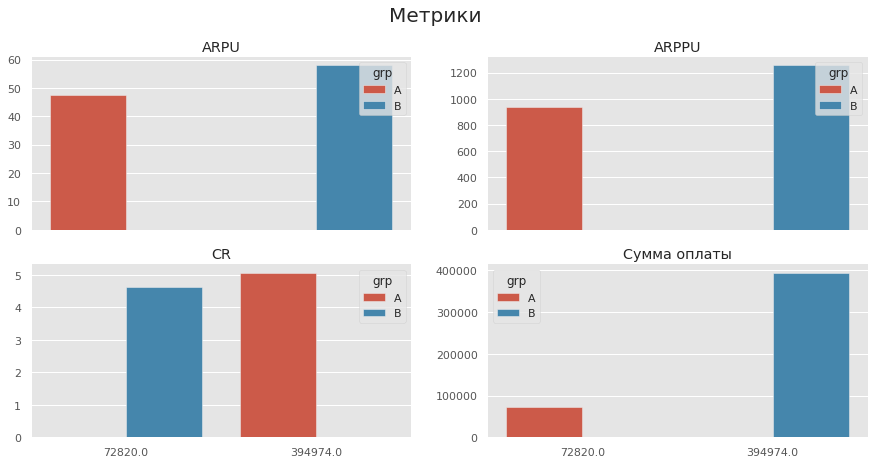

In [75]:
 def plot_show(metrics):
    figure, axes = plt.subplots(2, 2, sharex=True, figsize=(15, 7))
    figure.suptitle('Метрики', fontsize=20)
    sns.barplot(ax=axes[0, 0], x=metrics.ARPU, y='ARPU', data=metrics, hue='grp')
    axes[0, 0].set(title='ARPU')
    axes[0, 0].set(xlabel='')
    axes[0, 0].set(ylabel='')

    sns.barplot(ax=axes[0, 1], x=metrics.ARPPU, y='ARPPU', data=metrics, hue='grp')
    axes[0, 1].set(title='ARPPU')
    axes[0, 1].set(xlabel='')
    axes[0, 1].set(ylabel='')

    sns.barplot(ax=axes[1, 0], x=metrics.CR, y='CR', data=metrics, hue='grp')
    axes[1, 0].set(title='CR')
    axes[1, 0].set(xlabel='')
    axes[1, 0].set(ylabel='')

    sns.barplot(ax=axes[1, 1], x=metrics.rev_sum, y='rev_sum', data=metrics, hue='grp')
    axes[1, 1].set(title='Сумма оплаты')
    axes[1, 1].set(xlabel='')
    axes[1, 1].set(ylabel='')

    sns.despine()
    return plt.show()

plot_show(metrics)